**Question:**

Given an image from CIFAR10, feed it as input to a network and output the category of the image. The code should do the training of the network and then demonstrate it on images from a test set. Also it should show how a measure of performance during training, how the tuning and the final performance evaluation.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np

# from rich import print
import time 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
def timeSince(since: float) -> str:
    s = time.time() - since
    return f"{int(s/60):2}m {int(s%60):02}s"

In [3]:
# Set random seeds

torch.manual_seed(14)
torch.cuda.manual_seed(14)

## Loading and Normalizing the CIFAR10 Images

In [4]:
dataset_mean = np.array([0.4915, 0.4823, 0.4468])
dataset_std = np.array([0.2470, 0.2435, 0.2616])

transform = {
    'train': transforms.Compose([
#         transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(p=0.9),
        transforms.ToTensor(),
#         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        transforms.Normalize(dataset_mean, dataset_std)
     ]), 
    'test':  transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(dataset_mean, dataset_std)
     ])
}
    

batch_size = 32

kwargs = {'num_workers': 1, 'pin_memory': True, 'batch_size':batch_size}

trainset = CIFAR10(root='~/data', train=True, download=True, transform=transform['train'])
trainloader = DataLoader(trainset, shuffle=True, **kwargs)
 
testset = CIFAR10(root='~/data', train=False, download=True, transform=transform['test'])
testloader = DataLoader(testset, shuffle=False, **kwargs)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# Method Resolution Order

type(trainloader).__mro__,  type(testset).__mro__

((torch.utils.data.dataloader.DataLoader, typing.Generic, object),
 (torchvision.datasets.cifar.CIFAR10,
  torchvision.datasets.vision.VisionDataset,
  torch.utils.data.dataset.Dataset,
  typing.Generic,
  object))

### Defining a Function for Showing the Image(s)

In [6]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# functions to show an image with label
def imshow(img, labels, ncol=8, joint=False):
    if isinstance(img, torch.Tensor):
        img = torchvision.utils.make_grid(img).detach().numpy()
#     img = img / 2 + 0.5     # unnormalize
    img = img*dataset_std[:,None,None] + dataset_mean[:,None,None]
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()
    
    nrow = len(labels)//ncol # number of rows
    for i in range(0, nrow if nrow else 1):
        if not joint:
            print(' '.join(f"{classes[label]:5}" for label in labels[i*ncol: (i+1)*ncol]))
        else:
            print(' '.join(f"{classes[label1]}/{classes[label2]}" for label1, label2 in 
                 zip(labels[i*ncol*2: (i+1)*ncol*2: 2], labels[i*ncol*2+1: (i+1)*ncol*2: 2])))

### Illustrating some samples from CIFAR10

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


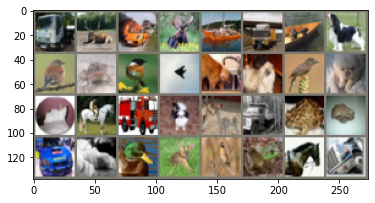

truck deer  car   deer  ship  truck ship  dog  
bird  frog  bird  plane cat   dog   bird  dog  
cat   horse truck dog   deer  truck frog  frog 
car   cat   bird  deer  bird  frog  horse truck


In [7]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images and thier labels
imshow(images, labels)

# Defining a Convolutional Neural Network Model for Classification

In [8]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [9]:
# Defining the model

class Block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.inout = (in_ch, out_ch)
        self.conv1 = nn.Conv2d(in_channels=in_ch, out_channels=out_ch, kernel_size=3, padding=1)
        nn.init.xavier_uniform_(self.conv1.weight)#, gain=nn.init.calculate_gain('relu'))
#         self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
#         nn.init.xavier_uniform_(self.conv2.weight)
        self.conv3 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        nn.init.xavier_uniform_(self.conv3.weight)
        self.bat1 = nn.BatchNorm2d(out_ch)
#         self.bat2 = nn.BatchNorm2d(out_ch)
        self.bat3 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()
        self.drop = nn.Dropout2d(0.25)
        self.maxpool = nn.MaxPool2d(2) 
    
    def forward(self, x):
        x = self.drop(self.relu(self.bat1(self.conv1(x))))
#         if 128 in self.inout:
#             x = self.drop(self.relu(self.bat2(self.conv2(x))))
        return self.maxpool(self.drop(self.relu(self.bat3(self.conv3(x)))))
    
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.chs=3,128,256,512,256
        self.convblocks = nn.ModuleList( [Block(self.chs[i], self.chs[i+1]) 
                                          for i in range(len(self.chs)-1)] )
        self.fcblock = nn.Sequential(
            nn.Linear(self.chs[-1]*4, self.chs[-1]), 
            nn.ReLU(),
#             nn.Linear(self.chs[-1], self.chs[-1]), 
#             nn.ReLU(),
            nn.Linear(self.chs[-1], 10),
        )
        
    def forward(self, x):
        for block in self.convblocks:
            x = block(x)
#         x = nn.MaxPool2d(2)(x)
        x = x.view(-1,self.chs[-1]*4)
        return self.fcblock(x)

model = Net()

print(model(torch.randn(1,3,32,32,)).shape)

torch.Size([1, 10])


## Model Summary

In [10]:
from torchsummary import summary
summary(model.to(device), input_size=(3, 32, 32), batch_size=batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [32, 128, 32, 32]           3,584
       BatchNorm2d-2          [32, 128, 32, 32]             256
              ReLU-3          [32, 128, 32, 32]               0
         Dropout2d-4          [32, 128, 32, 32]               0
            Conv2d-5          [32, 128, 32, 32]         147,584
       BatchNorm2d-6          [32, 128, 32, 32]             256
              ReLU-7          [32, 128, 32, 32]               0
         Dropout2d-8          [32, 128, 32, 32]               0
         MaxPool2d-9          [32, 128, 16, 16]               0
            Block-10          [32, 128, 16, 16]               0
           Conv2d-11          [32, 256, 16, 16]         295,168
      BatchNorm2d-12          [32, 256, 16, 16]             512
             ReLU-13          [32, 256, 16, 16]               0
        Dropout2d-14          [32, 256,

## Training the Neural Network

In [11]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from datetime import datetime


def fwd_pass(net, loader, loss_function, optimizer, train=False):
    if train: net.train()
    else:     net.eval()

    total_loss = 0
    y_pred, y = [], []
    for X, labels in loader: #LOADING THE DATA IN A BATCH
        X, labels = X.to(device), labels.to(device)
        # ===================forward=====================
        outputs = model(X)
        loss = loss_function(outputs, labels) 
        total_loss += loss.item()
        # ===================backward====================
        if train:
            optimizer.zero_grad()# zero the parameter gradients
            loss.backward()
            optimizer.step()
        # ===============stack predictions===============
        with torch.no_grad():
            y_hat = outputs.argmax(dim=1)
            y_pred.extend(y_hat.cpu().numpy().tolist())
            y.extend(labels.cpu().numpy().tolist())

    # =================return values=====================
    with torch.no_grad():
        total_loss /= len(loader.dataset)
        acc = accuracy_score(y, y_pred)*100
        f1 = f1_score(y, y_pred, average="weighted")*100

    return total_loss, acc, f1


#TRAINING THE NETWORK
def train(model, train_loader, test_loader,
          optimizer, loss_function, epoch_num=1, device=device):
    model.to(device)
    torch.manual_seed(14)
    
    logs = dict( trainlosses=list(), testlosses=list(), 
                 trainaccs=list(), testaccs=list() )
    start = time.time()
    print_every = epoch_num//10
    print(f"Training Process Starts at {datetime.now().strftime('%H:%M:%S')} ... ")
    # loop over the dataset multiple times
    for epoch in range(epoch_num+1):
        # Training
        if epoch > 0:  # test untrained net first
            train_loss, train_acc, train_f1 = fwd_pass(model, train_loader, loss_function, 
                                                       optimizer, train=True)
        else: train_loss, train_acc, train_f1 = np.inf, 0, 0 
            
        # Testing
        with torch.no_grad():
            test_loss, test_acc, test_f1 = fwd_pass(model, test_loader, loss_function, 
                                                    optimizer, train=False)
        # ===================log========================
        logs['trainlosses'].append(train_loss)
        logs['trainaccs'].append(train_acc)
        logs['testlosses'].append(test_loss)
        logs['testaccs'].append(test_acc)

        reset='\n' if epoch <= 4 or epoch%print_every==0 else '\r'
        print(f"Epoch[{epoch:2d}]>>>",
            f"Train/Test loss: {train_loss:.7f}/{test_loss:.7f},",
            f"Acc.: {train_acc:.2f}/{test_acc:.2f}",
            f"[[{timeSince(start)}]]", end=reset)

    print(f'Finished in {timeSince(start)}')
    return logs

In [12]:
model = Net()

criterion = nn.CrossEntropyLoss()
learning_rate = 1e-3
optimizer = optim.Adam( model.parameters(), lr=learning_rate, weight_decay=1e-5,)

logs = train(model, train_loader=trainloader, test_loader=testloader,
             optimizer=optimizer, loss_function=criterion, 
             epoch_num=200)

Training Process Starts at 00:19:34 ... 
Epoch[ 0]>>> Train/Test loss: inf/0.0720887, Acc.: 0.00/10.00 [[ 0m 05s]]
Epoch[ 1]>>> Train/Test loss: 0.0504331/0.0405997, Acc.: 40.39/51.73 [[ 1m 50s]]
Epoch[ 2]>>> Train/Test loss: 0.0382941/0.0317369, Acc.: 55.96/63.80 [[ 3m 35s]]
Epoch[ 3]>>> Train/Test loss: 0.0315842/0.0261405, Acc.: 64.23/70.44 [[ 5m 20s]]
Epoch[ 4]>>> Train/Test loss: 0.0273978/0.0234172, Acc.: 69.39/74.18 [[ 7m 06s]]
Epoch[20]>>> Train/Test loss: 0.0092907/0.0132677, Acc.: 89.88/86.35 [ 09s]]
Epoch[40]>>> Train/Test loss: 0.0061007/0.0134573, Acc.: 93.42/87.33 [ 13s]]
Epoch[60]>>> Train/Test loss: 0.0052504/0.0135987, Acc.: 94.41/87.47 [ 19s]]
Epoch[80]>>> Train/Test loss: 0.0049852/0.0140116, Acc.: 94.70/87.49 [ 26s]]
Epoch[100]>>> Train/Test loss: 0.0049291/0.0137048, Acc.: 94.76/87.81 [ 34s]]
Epoch[120]>>> Train/Test loss: 0.0046445/0.0132905, Acc.: 95.09/88.44 [ 43s]]
Epoch[140]>>> Train/Test loss: 0.0046188/0.0134387, Acc.: 95.22/88.18 [ 51s]]
Epoch[160]>>> Train

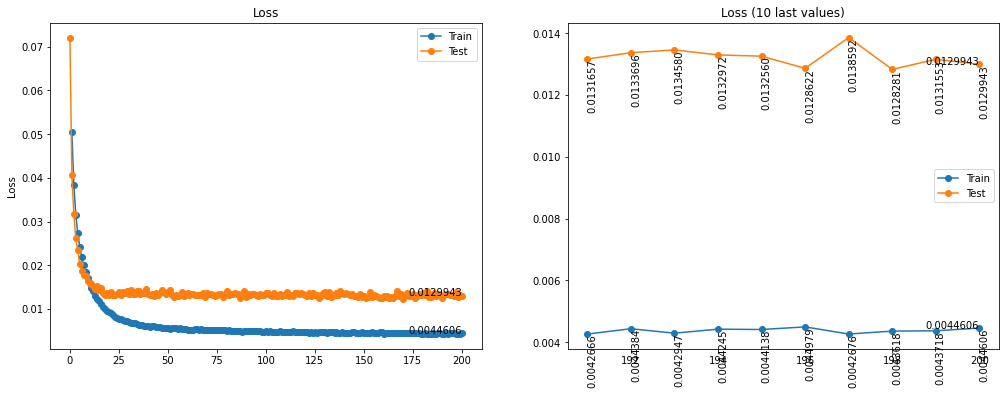

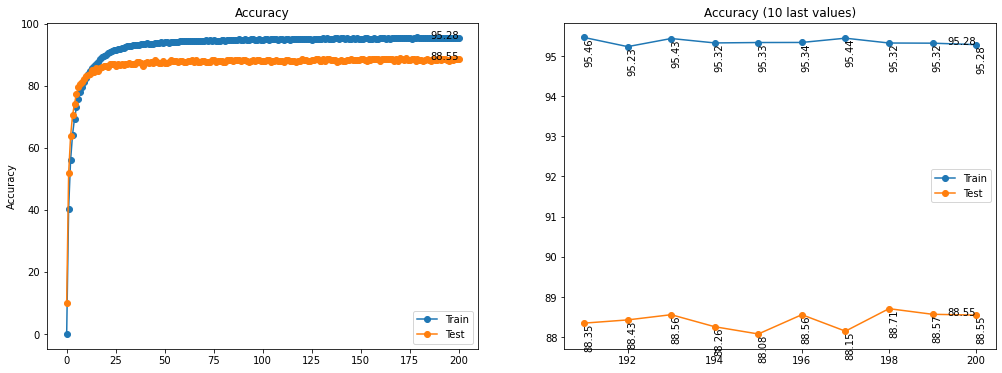

In [19]:
def res_plot(plotdata, xlabel='epoch', legend=['Train','Test'], title='Loss'):
    fig, axes = plt.subplots(1,2, figsize = (17,6))
    axes[0].set_ylabel(title)
    epochs = len(plotdata[0])-1
    for index, ax in enumerate(axes):
        n = 10 if index==1 else 0
        x = range(epochs-n+1, epochs+1) if index==1 else range(epochs+1)
        title = f"{title} ({n} last values)" if index==1 else title
#         ax.set_xlabel(xlabel)
        ax.set_title(title)
        ax.plot(x, plotdata[0][-n:], '-o', label=legend[0])
        ax.plot(x, plotdata[1][-n:], '-o', label=legend[1])
        p = 7 if 'loss'in title.lower() else 2
        if index==1:
            for i,j in list(zip(x,plotdata[1][-n:]))+list(zip(x, plotdata[0][-n:])):
                ax.annotate(f"{j:.{p}f}", xy=(i,j), rotation=90, va='top')
        ax.annotate(f"{plotdata[0][-1]:.{p}f}", xy=(len(plotdata[0])-1,plotdata[0][-1]),
                   ha="right")
        ax.annotate(f"{plotdata[1][-1]:.{p}f}", xy=(len(plotdata[1])-1,plotdata[1][-1]),
                   ha="right")
        ax.legend()
        if index==0:
            metric_name = f'images/cifar10-{title}[{datetime.now().strftime("%Y%m%d-%H%M")}].png'
            extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
            fig.savefig(metric_name, dpi=600, bbox_inches=extent.expanded(1.2, 1.2))
    plt.show()
    
res_plot((logs['trainlosses'], logs['testlosses']), title='Loss')
res_plot((logs['trainaccs'], logs['testaccs']), title='Accuracy' )

## Performance of the model per class

In [20]:
class_correct = [0.] * 10
class_total = [0.] * 10 
y_test, y_pred = [] , []

with torch.no_grad():
    for images, labels in testloader:
        outputs = model(images.to(device))
        _, predicted = torch.max(outputs, 1)
        predicted = predicted.cpu()
        c = (predicted == labels).squeeze()
        for i, label in enumerate(labels):
            class_correct[label] += c[i].item()
            class_total[label] += 1
        y_pred.extend(predicted.numpy())
        y_test.extend(labels.cpu().numpy())

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))



Accuracy of plane : 91 %
Accuracy of   car : 94 %
Accuracy of  bird : 83 %
Accuracy of   cat : 75 %
Accuracy of  deer : 90 %
Accuracy of   dog : 80 %
Accuracy of  frog : 92 %
Accuracy of horse : 91 %
Accuracy of  ship : 92 %
Accuracy of truck : 93 %


In [21]:
from sklearn.metrics import confusion_matrix, classification_report

ac = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred, target_names=classes)
print("Accuracy is :",ac) 
print(cr)

Accuracy is : 0.8855
              precision    recall  f1-score   support

       plane       0.89      0.92      0.90      1000
         car       0.95      0.94      0.95      1000
        bird       0.84      0.83      0.84      1000
         cat       0.78      0.76      0.77      1000
        deer       0.85      0.91      0.88      1000
         dog       0.86      0.80      0.83      1000
        frog       0.90      0.92      0.91      1000
       horse       0.92      0.91      0.92      1000
        ship       0.92      0.93      0.92      1000
       truck       0.94      0.93      0.94      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



### Confusion Matrix

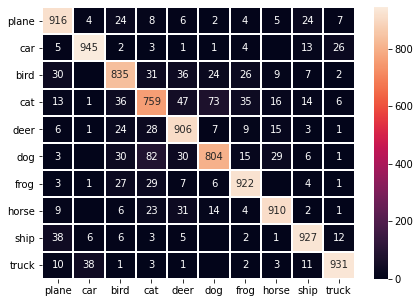

In [22]:
# visualising the confusion matrix

import seaborn as sns, pandas as pd

labels = pd.DataFrame(cm).applymap(lambda v: f"{v}" if v!=0 else f"")
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=labels, fmt='s', xticklabels=classes, yticklabels=classes, linewidths=0.1 )
confmat_name = f'images/cifar10-ConfusionMatrix[{datetime.now().strftime("%Y%m%d-%H%M")}].png'
plt.savefig(confmat_name, dpi=600)
plt.show()

## Saving the Model

In [26]:
model_name = f'cifar10[{datetime.now().strftime("%Y%m%d-%H%M")}].h5'
torch.save(model, model_name)
!cp {model_name} cifar10.h5
!ls -sh cifar10.h5

26M cifar10.h5
